<a target="_blank" href="https://colab.research.google.com/github/da-python/new-modul-python/blob/main/Lesson3/hometask/SyntheticRubber.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
!pip install yfinance

In [1]:
import yfinance as yf
import pandas as pd
import requests

In [2]:
crude_oil_ticker = "CL=F"
crude_oil = yf.Ticker(crude_oil_ticker)
hist = crude_oil.history()

In [3]:
data = yf.download(crude_oil_ticker)

[*********************100%***********************]  1 of 1 completed


# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Синтетический каучук" (СК), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на СК. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


* СК производиться из нефти. Один из известных способов производства предполагает, что из 10 баррелей нефти сделают одну тонну СК, а затраты на производство в районе 400 евро.

In [216]:
#исходные данные
#10 баррелей нефти -> 1 тонна СК
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

#Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

#Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Сonty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Ant':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    },
    'Mikhail':{
        'volumes': 400
    }
}
#Скидки
discounts = {'99': 0.01, # до 100 тонн 1%
             '299': 0.05, #  до 300 тонн 5%
             '300': 0.1}   # больше 300 тонн 10%


### Что нужно сделать?

1. Определить базовую формулу цены на заводе. То есть как бы выглядела цена на исторических данных. 
* Важно, чтобы цена покрывала расходы на производство и при этом была в рынке, то есть на уровне натурального каучука или с небольшим дисконтом, котировки на который можно взять с сайта http://www3.lgm.gov.my/mre/MonthlyPrices.aspx (в центах за килограм). Можно перевести в доллары за тонну.
2. Отобразить на графике.
3. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
4. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 



In [5]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
year = '2022'
month = '05'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)

In [6]:
#отобразить цены на сырую нефть
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385
2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978
2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601
2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770
2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131
...,...,...,...,...,...,...
2023-03-27,69.419998,73.099998,69.129997,72.809998,72.809998,353598
2023-03-28,72.860001,73.930000,72.190002,73.199997,73.199997,328472
2023-03-29,73.610001,74.370003,72.760002,72.970001,72.970001,312669


In [7]:
#Определить базовую формулу цены на заводе. То есть как бы выглядела цена на исторических данных

#т.к. в расчете базовой цене производственные затраты выражены в евро, погрузим к 
#таблице с ценами на сырую нефть курс евро-доллар и результирующие столбцы
eurusd_ticker = "EURUSD=X"
eurusd = yf.download(eurusd_ticker)
sr_price = data.merge(eurusd, left_on='Date', right_on='Date')[['Close_x', 'Close_y']]
#добавляем столбец себестоимости
sr_price['sr_cost'] = (sr_price.Close_x*10+PRODUCTION_COST*sr_price.Close_y) 

[*********************100%***********************]  1 of 1 completed


In [8]:
#Важно, чтобы цена покрывала расходы на производство и при этом была в рынке, 
#то есть на уровне натурального каучука или с небольшим дисконтом, 
#котировки на который можно взять с сайта http://www3.lgm.gov.my/mre/MonthlyPrices.aspx (в центах за килограм) 
#Можно перевести в доллары за тонну

#сведем массивы цен на синт.каучук с учетом рыночных цен (на натуральный каучук)

# выгружаем инфо о ценах на натуральный каучук (НК) за период, доступный из ранее полученной таблицы
from tqdm.auto import tqdm
nr_prices_list = pd.DataFrame()
min_date = sr_price.index.min()
max_date = sr_price.index.max()
for i in tqdm(range(max_date.year-min_date.year+1)):
    for j in range(1,13):
        month = j
        year = min_date.year + i
        url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
        res = requests.get(url)
        rj = res.json()
        df = pd.json_normalize(rj)
        nr_prices_list = pd.concat([nr_prices_list, df])
nr_prices_list = nr_prices_list[nr_prices_list['grade']=='SMR CV'] #оставляем только каучук типа "SMR CV"
nr_prices_list = nr_prices_list[['date', 'us']] #оставляем только дату и цену для дальнейшего анализа
nr_prices_list

  0%|          | 0/21 [00:00<?, ?it/s]

,date,us
0,2003-01-30,111.65
7,2003-01-29,111.25
14,2003-01-28,111.00
21,2003-01-27,111.40
28,2003-01-24,111.55
...,...,...
126,2023-03-07,212.85
133,2023-03-06,212.50
140,2023-03-03,212.20
147,2023-03-02,210.90


In [9]:
#приводим связывающие столбцы к единому типу и объединяем таблицы
nr_prices_list['date'] = pd.to_datetime(nr_prices_list['date'])
sr_price = sr_price.merge(nr_prices_list, left_on='Date', right_on='date')

In [10]:
sr_price

,Close_x,Close_y,sr_cost,date,us
0,29.950001,1.196501,778.100557,2003-12-01,148.65
1,30.780001,1.208897,791.358995,2003-12-02,147.10
2,31.100000,1.212298,795.919027,2003-12-03,145.75
3,31.260000,1.208094,795.837698,2003-12-04,144.55
4,30.730000,1.218695,794.777870,2003-12-05,145.10
...,...,...,...,...,...
4559,72.809998,1.077819,1159.227381,2023-03-27,200.95
4560,73.199997,1.080707,1164.282846,2023-03-28,202.15
4561,72.970001,1.083952,1163.280840,2023-03-29,202.55
4562,74.370003,1.084363,1177.445412,2023-03-30,199.85


In [11]:
sr_price['market_price'] = pd.to_numeric(sr_price['us'])*10 #пересчитываем в доллары за тонну
sr_price = sr_price[['date', 'Close_y', 'sr_cost', 'market_price']]
sr_price.rename(columns = {'Close_y': 'EURUSD'}, inplace=True)
sr_price

,date,Close_y,sr_cost,market_price
0,2003-12-01,1.196501,778.100557,1486.5
1,2003-12-02,1.208897,791.358995,1471.0
2,2003-12-03,1.212298,795.919027,1457.5
3,2003-12-04,1.208094,795.837698,1445.5
4,2003-12-05,1.218695,794.777870,1451.0
...,...,...,...,...
4559,2023-03-27,1.077819,1159.227381,2009.5
4560,2023-03-28,1.080707,1164.282846,2021.5
4561,2023-03-29,1.083952,1163.280840,2025.5
4562,2023-03-30,1.084363,1177.445412,1998.5


In [18]:
#т.к. себестоимость СК ниже НК почти в 2 раза, то мы можем установить цену СК таким образом, чтобы она была ниже НК на 10%
#дополнительно выведем итоговую наценку
sr_price = sr_price.copy() #избавляемся от предупреждения "A value is trying to be set on a copy of a slice from a DataFrame"
sr_price['res_price'] = sr_price['market_price']*0.9
sr_price['marg'] = sr_price['res_price']/sr_price['sr_cost']
sr_price

,date,EURUSD,sr_cost,market_price,res_price,marg
0,2003-12-01,1.196501,778.100557,1486.5,1337.85,1.719379
1,2003-12-02,1.208897,791.358995,1471.0,1323.90,1.672945
2,2003-12-03,1.212298,795.919027,1457.5,1311.75,1.648095
3,2003-12-04,1.208094,795.837698,1445.5,1300.95,1.634693
4,2003-12-05,1.218695,794.777870,1451.0,1305.90,1.643101
...,...,...,...,...,...,...
4559,2023-03-27,1.077819,1159.227381,2009.5,1808.55,1.560134
4560,2023-03-28,1.080707,1164.282846,2021.5,1819.35,1.562636
4561,2023-03-29,1.083952,1163.280840,2025.5,1822.95,1.567076
4562,2023-03-30,1.084363,1177.445412,1998.5,1798.65,1.527587


In [13]:
#проверим минимальную наценку за 20 лет (чтобы убедиться, что цена на СК выше с/с (маржинальность>1))
sr_price.marg.min()

1.173600904881348

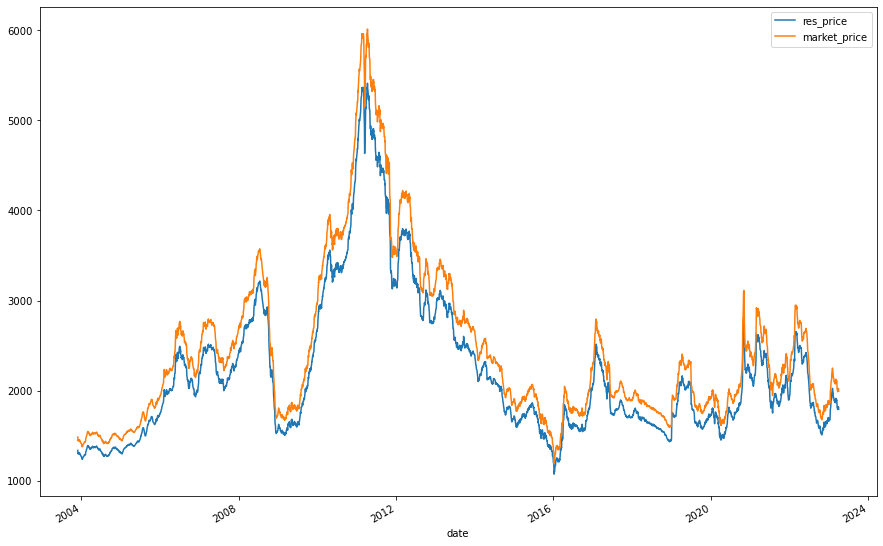

In [14]:
#выводим график цены на СК за 20 лет
import matplotlib.pyplot as plt
sr_price.plot(x='date', y=['res_price', 'market_price'], figsize=(15, 10))
plt.show()

In [211]:
#функция для отражения формулы расчета стоимости СК для клиента по актуальным ценам
#вывод результата будет зависеть от номера задачи:
#для 2ой задачи возвращает сумму скидки
#для 3ей - выводим актуальную цену 
#для 4ой - выводим расчет формулы для клиента
import numpy as np
def pricing(name, number_of_task):
    volume = customers.get(name).get('volumes')
    actual_price = float(sr_price.loc[sr_price.date == sr_price.date.max()].res_price.to_string(index=False))
    eurusd_conv = float(sr_price.loc[sr_price.date == sr_price.date.max()].EURUSD.to_string(index=False))
    location = customers.get(name).get('location')
    logistix_price = 0
    #принимаем, что цена логистики указана за 1 тонну (условием не задано); приводим к долларам
    if location == 'EU': logistix_price = EU_LOGISTIC_COST_EUR*eurusd_conv
    elif location == 'CN': logistix_price = CN_LOGISTIC_COST_USD
    if number_of_task == 4:
        return f'запрошенный объем * (текущая цена за 1т + цена доставки за 1т) = итоговая стоимость с доставкой без скидки\n\n{np.round(volume, decimals=2)} * (${np.round(actual_price, decimals=2)} + ${np.round(logistix_price, decimals=2)}) = ${np.round(volume*(actual_price+logistix_price), decimals=2)}'
    elif number_of_task == 3:
        return np.round(volume*(actual_price+logistix_price), decimals=2)
    elif number_of_task == 2:
        if volume >= int(list(discounts.keys())[-1]): #исходим из того, что последний ключ словаря - объем для максимальной скидки ("от ОБЪЕМ и выше"), а ключи расположены в порядке возрастания
            return np.round(volume*actual_price*float(list(discounts.values())[-1]))
        else:
            for i in range(len(discounts.keys())-1): #избегаем последний элемент, т.к. мы его уже проверили
                if volume > int(list(discounts.keys())[i]): continue
                else: 
                    return np.round(volume*actual_price*float(list(discounts.values())[i]))

In [22]:
#модуль для работы с MS Excel/Word
!pip install openpyxl
!pip install python-docx
import openpyxl

In [210]:
#Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой)
#Записать все в один эксель файл, на разных листах. Каждый лист - название клиента
from pandas.io.excel import ExcelWriter
file = openpyxl.Workbook()
file.active.title = 'Технический лист'
for name in customers.keys():
    q = file.create_sheet(title=name)
    file.active = q
    q["A1"] = "Исходные данные:"
    q["B2"] = f'запрошенный объем: {customers[name].get("volumes")}'
    q["B3"] = f'доставка: {customers[name].get("location")}'
    q["B4"] = f'Актуальная цена за запрошенный объем синтетического каучука с доставкой составляет: ${pricing(name, 3)}'
    q["B5"] = f'Скидка на объем составляет: ${pricing(name, 2)}'
    q["B6"] = f'Итого с учетом скидки: ${pricing(name, 3)-pricing(name, 2)}'   
file.save('Цены для покупателей.xlsx')
with ExcelWriter('Цены для покупателей.xlsx', engine="openpyxl", mode='a', if_sheet_exists='replace') as writer:
    sr_price.to_excel(writer, sheet_name='Технический лист', index=False)

In [214]:
#Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
#Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
#Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf) с именем клиента…
from docx import Document
import os
if not os.path.isdir("для клиентов"):
    os.mkdir("для клиентов")
for name in customers.keys():
    doc = Document()
    doc.add_paragraph(pricing(name, 4))
    doc.add_paragraph(f'Ваша скидка составляет: ${pricing(name, 2)}\n\nИтоговая стоимость с учетом скидки: ${pricing(name, 3)-pricing(name, 2)}')
    doc.save(f'./для клиентов/{name}.docx')

# Задание 2

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

In [215]:
print('Имя клиента: стоимость без скидки --- стоимость со скидкой')
for name in customers.keys():
    print(f'{name}: ${pricing(name, 3)} --- ${pricing(name, 3)-pricing(name, 2)}')

Имя клиента: стоимость без скидки --- стоимость со скидкой
Сonty: $365523.25 --- $347573.25
Triangle: $57751.5 --- $57212.5
Stone: $274142.43 --- $260679.43
Ant: $127933.14 --- $126676.14


# Задание 3

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать СК для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать СК с завода самостоятельно.
На основе тех данных, которые уже есть предложите цену новому клиенту в рублях. 



In [224]:
usdrub = yf.Ticker('RUB=X')
rate = usdrub.info['regularMarketPrice']
print(f'{list(customers.keys())[-1]}, ваша итоговая стоимость с учетом скидки составляет: {(pricing(list(customers.keys())[-1], 3)-pricing(list(customers.keys())[-1], 2))*rate} рублей')

Mikhail, ваша итоговая стоимость с учетом скидки составляет: 49745861.64 рублей
